In [1]:
#For running the model:
import numpy as np
import os
import gzip
import pickle
import urllib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator
from scipy import signal
import scipy
import activeLearningCortical as ALC
%load_ext autoreload
%autoreload 2

# Load Dataset

Samples ::  9410
Neurons ::  64  ; Stimulis ::  49


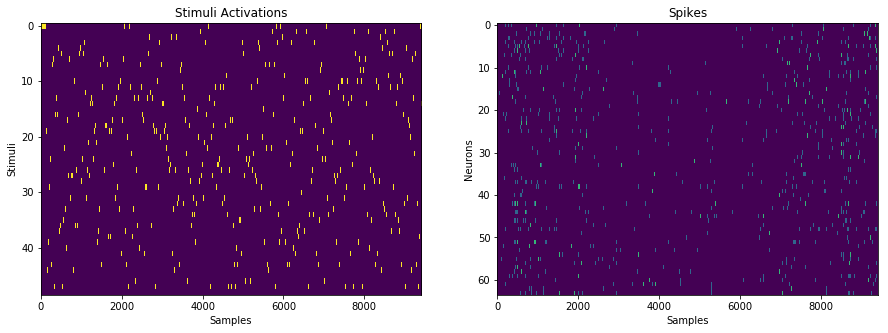

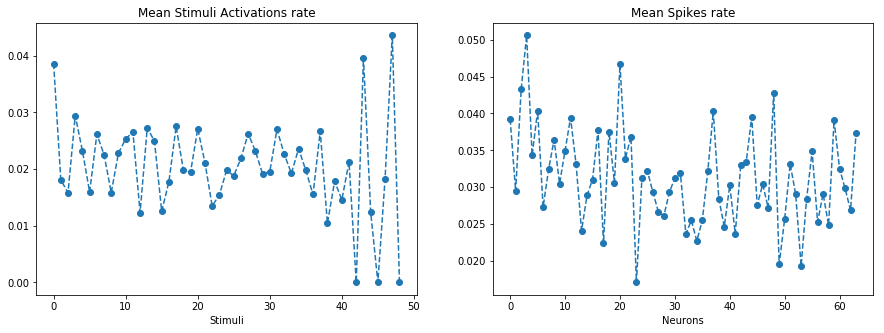

In [2]:

stimuli, spikes,_,_,_ = ALC.utils.load_datasets('lt3_000_002')
stimuli, spikes,_,_,_ = ALC.utils.load_datasets('lt3_000_003')

spikes = np.round((spikes*1)).astype('int') #Get Integers
print('Samples :: ', str(spikes.shape[0]))
print('Neurons :: ', str(spikes.shape[1]) , ' ; Stimulis :: ', str(stimuli.shape[1]))


#Plot Some Data
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('Stimuli Activations')
plt.imshow(stimuli.T,aspect='auto')
plt.xlabel('Samples')
plt.ylabel('Stimuli')

plt.subplot(122)
plt.title('Spikes')
plt.imshow(spikes.T,aspect='auto')
plt.xlabel('Samples')
plt.ylabel('Neurons')
plt.show()

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('Mean Stimuli Activations rate')
plt.plot(np.mean(stimuli,axis = 0),'--o')
plt.xlabel('Stimuli')

plt.subplot(122)
plt.title('Mean Spikes rate')
plt.plot(np.mean(spikes,axis = 0),'--o')
plt.xlabel('Neurons')
plt.show()

# Evaluate Spiking Activity Across Frames

In [3]:
def moving_average(X,window):
    Xma = np.zeros([X.shape[0]-window+1,X.shape[1]])
    for i in np.arange(X.shape[1]):
        Xma[:,i] = np.convolve(X[:,i], np.ones((window,))/window, mode='valid')
    return Xma

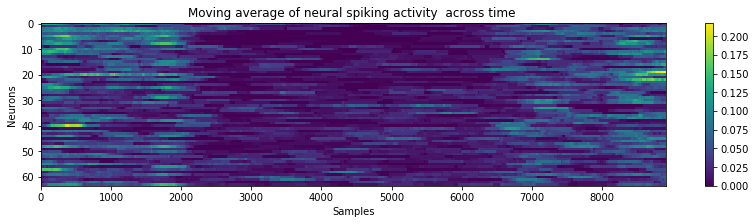

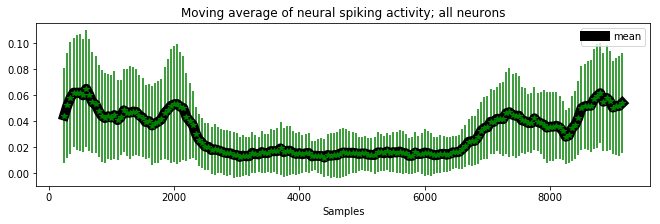

In [4]:
window = 500
spikes_ma = moving_average(spikes,500)

plt.figure(figsize = (14,3))

plt.title('Moving average of neural spiking activity  across time ')
plt.imshow(spikes_ma.transpose(),aspect = 'auto')
plt.xlabel('Samples')
plt.ylabel('Neurons')
plt.colorbar()
plt.show()

plt.figure(figsize = (11,3))

x_p = np.arange(spikes_ma.shape[0])+250
ma_p = np.mean(spikes_ma,axis = 1)
mstd_p = np.std(spikes_ma,axis = 1)

plt.errorbar(x_p[::50],ma_p[::50],mstd_p[::50],fmt =  '*g')
plt.plot(x_p[::50],ma_p[::50],'k',linewidth=10,label = 'mean')
plt.legend()
plt.title('Moving average of neural spiking activity; all neurons')
plt.xlabel('Samples')
plt.show()

# Build Model

In [10]:
#Samples to use

ni_samples = 0 #initial Sample
nf_samples = 3000 #final Sample
spikes_model = spikes[ni_samples:nf_samples,:]
stimuli_model = stimuli[ni_samples:nf_samples,:]

#Model Parameters #
D_c_u = -2 
D_c_l = -5
D_s_u = -2
D_s_l = -5
k = 5
kappa = 10
nu = 1
n_splits=1
sensitivity_th = 0.2
gamma = 0.001
approx_gamma = 0.01
seed = 0

logfile = 'our_spikes_database/RDdata.txt'
checkpoint = 'our_spikes_database/RDdata_check'

# Fit model to data

In [11]:
#Build new model
model = ALC.ClassModel(X=spikes_model, I=stimuli_model,
            D_c_l=D_c_l, D_c_u=D_c_u, D_s_l=D_s_l, D_s_u=D_s_u,
            k=k,kappa=kappa,
            gamma=gamma,approx_gamma=approx_gamma,
            nu=nu, n_splits=n_splits,sensitivity_th=sensitivity_th,
            logfile=logfile,checkpoint=checkpoint)
model.seed = seed

#compute network inference
model.updateModel()


## Inferred Connections with samples from 0 to 3000  ##


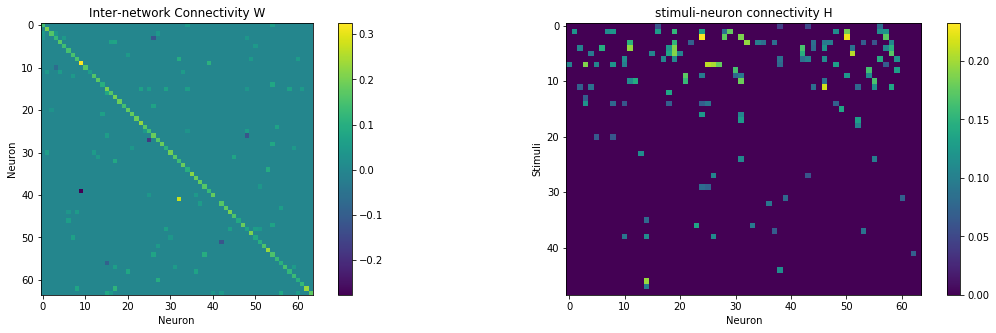

In [18]:
plt.figure(figsize = (20,5))

print('## Inferred Connections with samples from ' + str(ni_samples) + ' to ' + str(nf_samples) + '  ##')
plt.subplot(1,2,1)
plt.title('Inter-network Connectivity W')
plt.imshow(model.W)
plt.ylabel('Neuron')
plt.xlabel('Neuron')
plt.colorbar()

plt.subplot(1,2,2)
plt.title('stimuli-neuron connectivity H')
plt.imshow(model.H)
plt.ylabel('Stimuli')
plt.xlabel('Neuron')
plt.colorbar()

plt.show()

# Obtain Active learning sampling distribution

In [13]:
stimuli_probability_AL = model.getActiveLearningDistribution()
uniform_probability = np.ones(model.H.shape[0])
uniform_probability /= uniform_probability.sum()

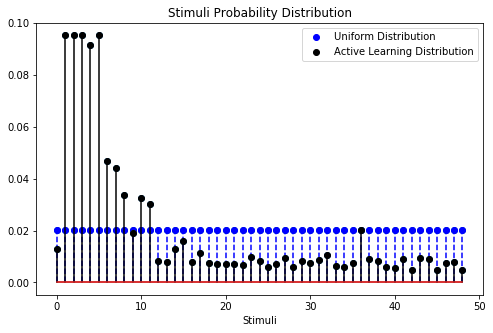

In [14]:
plt.figure(figsize = (8,5))
plt.stem(uniform_probability,'b--')
plt.plot(uniform_probability,'bo',label = 'Uniform Distribution')
plt.stem(stimuli_probability_AL,'k')
plt.plot(stimuli_probability_AL,'ko',label = 'Active Learning Distribution')

plt.legend()
plt.title('Stimuli Probability Distribution')
plt.xlabel('Stimuli')
plt.show()

# Sample Stimuli and Simulate System

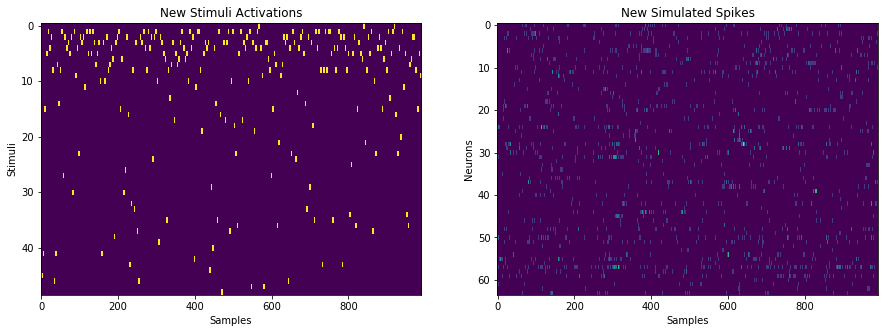

In [17]:
n_samples_simulate = 1000
dframes_stimuli = 4

#Get Stimulis from AL probability distribution
stimuli_new = ALC.getSampledStimuli(n_samples_simulate, dframes_stimuli, stimuli_probability_AL)

#Get Simulated Spikes
X_new, S_new = ALC.generate_spikes(model.W_kernel, model.H_kernel, model.b,
                                   stimuli_new, kappa=kappa,
                                   expected=False) #if expected true you get the expected spiking rates


## Add to previous Data
model.addData(I=S_new,X=X_new)


plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('New Stimuli Activations')
plt.imshow(S_new.T,aspect='auto')
plt.xlabel('Samples')
plt.ylabel('Stimuli')

plt.subplot(122)
plt.title('New Simulated Spikes')
plt.imshow(X_new.T,aspect='auto')
plt.xlabel('Samples')
plt.ylabel('Neurons')
plt.show()

